In [2]:
import numpy as np
import awkward as ak
import uproot
import vector
vector.register_awkward()
import os
import shutil
import zipfile
import tarfile
import urllib
import requests
from tqdm import tqdm

In [3]:
import uproot
import awkward as ak
import numpy as np
import torch

with uproot.open("/home/sandeep/Desktop/combined_qcd_higgs.root") as f:
    tree = f["tree"]
    table = tree.arrays(
        ["part_px", "part_py", "part_pz", "part_energy"],
        library="ak"
    )

def pad(a, maxlen=128):
    a = ak.pad_none(a, maxlen, clip=True)
    a = ak.fill_none(a, 0)
    return ak.to_numpy(a)

pf_v = np.stack([
    pad(table["part_px"]),
    pad(table["part_py"]),
    pad(table["part_pz"]),
    pad(table["part_energy"]),
], axis=1)   # shape: (N, 4, 128)


In [4]:
print(pf_v.shape)  # (37870, 4, 128)


(37870, 4, 128)


In [5]:
pf_mask = (pf_v[:, 3:4, :] != 0)   # energy != 0


In [6]:
print(pf_mask.shape)  # (37870, 1, 128)


(37870, 1, 128)


In [7]:
def _pad(a, maxlen, value=0, dtype="float32"):
    """
    Pads or truncates a jagged Awkward array to fixed length.
    Output shape: (N, maxlen)
    """
    if isinstance(a, ak.Array):
        a = ak.fill_none(ak.pad_none(a, maxlen, clip=True), value)
        return ak.values_astype(a, dtype)
    else:
        out = np.full((len(a), maxlen), value, dtype=dtype)
        for i, row in enumerate(a):
            if len(row) == 0:
                continue
            trunc = row[:maxlen].astype(dtype)
            out[i, :len(trunc)] = trunc
        return out


# --------------------------------------------------
# Main reader (Particle Transformer compatible)
# --------------------------------------------------
def read_file(
    filepath,
    tree_name="tree",
    max_num_particles=128,
    particle_features=(
        "part_pt",
        "part_eta",
        "part_phi",
        "part_energy",
        "part_charge",
        "part_isChargedHadron",
        "part_isNeutralHadron",
        "part_isPhoton",
        "part_isElectron",
        "part_isMuon",
    ),
    jet_features=(
        "jet_pt",
        "jet_eta",
        "jet_phi",
        "jet_energy",
    ),
    label_name="class_id",   # binary or multi-class
):
    """
    Loads a ROOT file and returns Particle Transformer–ready tensors.

    Returns
    -------
    x_particles : np.ndarray
        Shape (N_jets, N_particle_features, max_num_particles)

    x_jets : np.ndarray
        Shape (N_jets, N_jet_features)

    y : np.ndarray
        Shape (N_jets,)
    """

    # -----------------------------
    # Load ROOT arrays
    # -----------------------------
    with uproot.open(filepath) as f:
        tree = f[tree_name]
        table = tree.arrays(library="ak")

    # -----------------------------
    # Build particle 4-vectors
    # -----------------------------
    p4 = vector.zip(
        {
            "px": table["part_px"],
            "py": table["part_py"],
            "pz": table["part_pz"],
            "energy": table["part_energy"],
        }
    )

    table["part_pt"] = p4.pt
    table["part_eta"] = p4.eta
    table["part_phi"] = p4.phi

    # -----------------------------
    # Particle tensor
    # -----------------------------
    x_particles = np.stack(
        [
            ak.to_numpy(_pad(table[name], max_num_particles))
            for name in particle_features
        ],
        axis=1,   # (N, features, particles)
    ).astype("float32")

    # -----------------------------
    # Jet-level tensor
    # -----------------------------
    x_jets = np.stack(
        [ak.to_numpy(table[name]).astype("float32") for name in jet_features],
        axis=1,
    )

    # -----------------------------
    # Labels
    # -----------------------------
    y = ak.to_numpy(table[label_name]).astype("int64")

    return x_particles, x_jets, y


In [8]:
x_particles, x_jets, y = read_file(
    "/home/sandeep/Desktop/combined_qcd_higgs.root"
)

print("x_particles:", x_particles.shape)
print("x_jets:", x_jets.shape)
print("labels:", np.unique(y, return_counts=True))


x_particles: (37870, 10, 128)
x_jets: (37870, 4)
labels: (array([0, 1]), array([16780, 21090]))


In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

pf_x = torch.tensor(x_particles, dtype=torch.float32).to(device)
pf_v = torch.tensor(pf_v, dtype=torch.float32).to(device)
pf_mask = torch.tensor(pf_mask, dtype=torch.bool).to(device)
y = torch.tensor(y, dtype=torch.long).to(device)


In [10]:
assert pf_x.shape[0] == pf_v.shape[0] == pf_mask.shape[0] == y.shape[0]
assert pf_x.shape[2] == pf_v.shape[2] == pf_mask.shape[2]


In [11]:
from sklearn.model_selection import train_test_split
import numpy as np
import torch


In [12]:
N = y.shape[0]
indices = np.arange(N)


In [13]:
train_idx, val_idx = train_test_split(
    indices,
    test_size=0.2,
    stratify=y.cpu().numpy(),
    random_state=42
)


In [14]:
train_idx = torch.tensor(train_idx, device=pf_x.device)
val_idx   = torch.tensor(val_idx,   device=pf_x.device)


In [19]:
print("Train size:", train_idx.numel())
print("Val size:", val_idx.numel())

print("Train label balance:",
      torch.bincount(y[train_idx]).cpu().numpy())

print("Val label balance:",
      torch.bincount(y[val_idx]).cpu().numpy())


Train size: 30296
Val size: 7574
Train label balance: [13424 16872]
Val label balance: [3356 4218]


In [20]:
from ParticleTransformer import ParticleTransformer1 


In [21]:
device = pf_x.device  # already cuda or cpu

model = ParticleTransformer1(
    input_dim=pf_x.shape[1],   # = 10 particle features
    num_classes=2,             # QCD vs Higgs
    pair_input_dim=4,          # (pt, y, phi, m) derived from 4-vectors
    # embed_dims=[128, 512, 128],
    embed_dims=[64, 128, 64],
    pair_embed_dims=[32, 32, 32],
    num_heads=8,
    num_layers=6,
    num_cls_layers=2,
    fc_params=[(128, 0.1)],
    trim=True,
    for_inference=False,
    use_amp=True
).to(device)


In [22]:
# parameter count
n_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {n_params/1e6:.2f} M")

# quick forward shape check (1 mini-batch)
with torch.no_grad():
    idx = train_idx[:4]
    out = model(
        pf_x[idx],
        pf_v[idx],
        pf_mask[idx]
    )
    print("Output shape:", out.shape)


Model parameters: 0.43 M
Output shape: torch.Size([4, 2])


In [23]:
import torch.nn as nn

criterion = nn.CrossEntropyLoss()


In [24]:
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=3e-4,
    weight_decay=1e-4
)


In [26]:
scaler = torch.amp.GradScaler(enabled=True)


In [27]:
print("Optimizer:", type(optimizer).__name__)
print("Loss:", type(criterion).__name__)
print("AMP enabled:", scaler.is_enabled())


Optimizer: AdamW
Loss: CrossEntropyLoss
AMP enabled: True


In [ ]:
def train_one_epoch(batch_size=128):
    model.train()

    # shuffle training indices
    perm = torch.randperm(train_idx.numel(), device=pf_x.device)

    total_loss = 0.0

    for i in range(0, perm.numel(), batch_size):
        batch_ids = train_idx[perm[i:i + batch_size]]

        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast(enabled=True):
            logits = model(
                pf_x[batch_ids],
                pf_v[batch_ids],
                pf_mask[batch_ids]
            )
            loss = criterion(logits, y[batch_ids])

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * batch_ids.numel()

    return total_loss / train_idx.numel()


In [29]:
loss = train_one_epoch()
print(f"Training loss (epoch 1): {loss:.4f}")


/tmp/ipykernel_516837/670010588.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Training loss (epoch 1): 0.5497


In [30]:
from sklearn.metrics import roc_auc_score

@torch.no_grad()
def validate(batch_size=256):
    model.eval()

    probs = []
    labels = []

    for i in range(0, val_idx.numel(), batch_size):
        batch_ids = val_idx[i:i + batch_size]

        logits = model(
            pf_x[batch_ids],
            pf_v[batch_ids],
            pf_mask[batch_ids]
        )

        # probability for class = 1 (Higgs)
        p = torch.softmax(logits, dim=1)[:, 1]

        probs.append(p.cpu())
        labels.append(y[batch_ids].cpu())

    probs = torch.cat(probs).numpy()
    labels = torch.cat(labels).numpy()

    auc = roc_auc_score(labels, probs)
    return auc, probs, labels


In [31]:
auc, _, _ = validate()
print(f"Validation AUC: {auc:.4f}")


Validation AUC: 0.8074


In [32]:
@torch.no_grad()
def validation_loss(batch_size=256):
    model.eval()
    total_loss = 0.0
    total = 0

    for i in range(0, val_idx.numel(), batch_size):
        batch_ids = val_idx[i:i + batch_size]

        logits = model(
            pf_x[batch_ids],
            pf_v[batch_ids],
            pf_mask[batch_ids]
        )

        loss = criterion(logits, y[batch_ids])
        total_loss += loss.item() * batch_ids.numel()
        total += batch_ids.numel()

    return total_loss / total


In [33]:
# num_epochs = 10

# history = {
#     "loss": [],
#     "val_auc": []
# }

# for epoch in range(1, num_epochs + 1):
#     loss = train_one_epoch(batch_size=128)
#     auc, _, _ = validate(batch_size=256)

#     history["loss"].append(loss)
#     history["val_auc"].append(auc)

#     print(f"Epoch {epoch:02d} | loss={loss:.4f} | val AUC={auc:.4f}")
num_epochs = 10

history = {
    "train_loss": [],
    "val_loss": [],
    "val_auc": []
}

for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch(batch_size=128)
    val_loss = validation_loss(batch_size=256)
    val_auc, _, _ = validate(batch_size=256)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_auc"].append(val_auc)

    print(
        f"Epoch {epoch:02d} | "
        f"train loss={train_loss:.4f} | "
        f"val loss={val_loss:.4f} | "
        f"val AUC={val_auc:.4f}"
    )


/tmp/ipykernel_516837/670010588.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
/home/sandeep/Desktop/particle_transformer/ParticleTransformer.py:549: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.use_amp):
/home/sandeep/anaconda3/envs/gnnhep/lib/python3.12/site-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 01 | train loss=0.4934 | val loss=0.4923 | val AUC=0.8291


/tmp/ipykernel_516837/670010588.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
/home/sandeep/Desktop/particle_transformer/ParticleTransformer.py:549: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.use_amp):
/home/sandeep/anaconda3/envs/gnnhep/lib/python3.12/site-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 02 | train loss=0.4813 | val loss=0.4758 | val AUC=0.8369


/tmp/ipykernel_516837/670010588.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
/home/sandeep/Desktop/particle_transformer/ParticleTransformer.py:549: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.use_amp):
/home/sandeep/anaconda3/envs/gnnhep/lib/python3.12/site-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 03 | train loss=0.4672 | val loss=0.4592 | val AUC=0.8446


/tmp/ipykernel_516837/670010588.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
/home/sandeep/Desktop/particle_transformer/ParticleTransformer.py:549: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.use_amp):
/home/sandeep/anaconda3/envs/gnnhep/lib/python3.12/site-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 04 | train loss=0.4619 | val loss=0.4792 | val AUC=0.8473


/tmp/ipykernel_516837/670010588.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
/home/sandeep/Desktop/particle_transformer/ParticleTransformer.py:549: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.use_amp):
/home/sandeep/anaconda3/envs/gnnhep/lib/python3.12/site-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 05 | train loss=0.4628 | val loss=0.4702 | val AUC=0.8429


/tmp/ipykernel_516837/670010588.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
/home/sandeep/Desktop/particle_transformer/ParticleTransformer.py:549: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.use_amp):
/home/sandeep/anaconda3/envs/gnnhep/lib/python3.12/site-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 06 | train loss=0.4559 | val loss=0.4552 | val AUC=0.8509


/tmp/ipykernel_516837/670010588.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
/home/sandeep/Desktop/particle_transformer/ParticleTransformer.py:549: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.use_amp):
/home/sandeep/anaconda3/envs/gnnhep/lib/python3.12/site-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 07 | train loss=0.4528 | val loss=0.4549 | val AUC=0.8498


/tmp/ipykernel_516837/670010588.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
/home/sandeep/Desktop/particle_transformer/ParticleTransformer.py:549: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.use_amp):
/home/sandeep/anaconda3/envs/gnnhep/lib/python3.12/site-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 08 | train loss=0.4517 | val loss=0.4555 | val AUC=0.8497


/tmp/ipykernel_516837/670010588.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
/home/sandeep/Desktop/particle_transformer/ParticleTransformer.py:549: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.use_amp):
/home/sandeep/anaconda3/envs/gnnhep/lib/python3.12/site-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 09 | train loss=0.4459 | val loss=0.4490 | val AUC=0.8556


/tmp/ipykernel_516837/670010588.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
/home/sandeep/Desktop/particle_transformer/ParticleTransformer.py:549: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.use_amp):
/home/sandeep/anaconda3/envs/gnnhep/lib/python3.12/site-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 10 | train loss=0.4452 | val loss=0.4451 | val AUC=0.8548


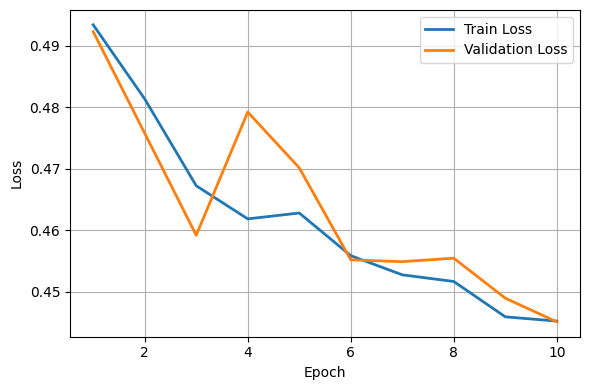

In [34]:
import matplotlib.pyplot as plt

epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(6, 4))
plt.plot(epochs, history["train_loss"], label="Train Loss", lw=2)
plt.plot(epochs, history["val_loss"], label="Validation Loss", lw=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/home/sandeep/Desktop/particle_transformer/ParticleTransformer.py:549: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.use_amp):
/home/sandeep/anaconda3/envs/gnnhep/lib/python3.12/site-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


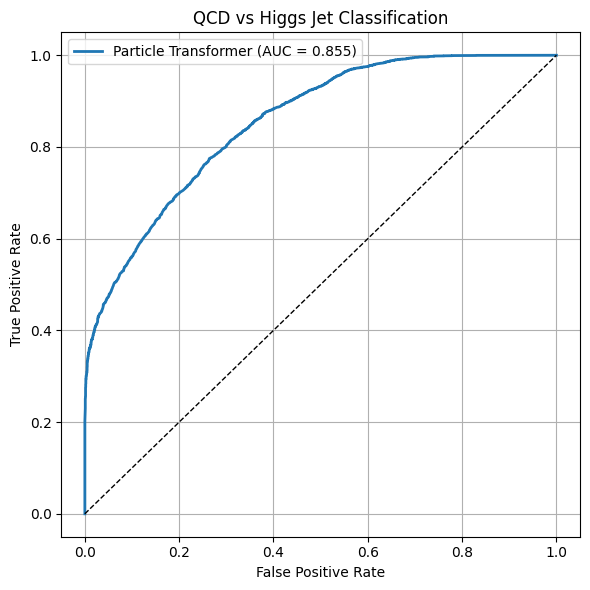

In [35]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

auc, probs, labels = validate()

fpr, tpr, _ = roc_curve(labels, probs)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, lw=2, label=f"Particle Transformer (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("QCD vs Higgs Jet Classification")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [36]:
from sklearn.metrics import confusion_matrix
import numpy as np


In [37]:
auc, probs, labels = validate(batch_size=256)

y_pred = (probs > 0.5).astype(int)


/home/sandeep/Desktop/particle_transformer/ParticleTransformer.py:549: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.use_amp):
/home/sandeep/anaconda3/envs/gnnhep/lib/python3.12/site-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


In [38]:
cm = confusion_matrix(labels, y_pred)
cm_percent = cm / cm.sum(axis=1, keepdims=True) * 100

print("Confusion Matrix (%):")
print(cm_percent)


Confusion Matrix (%):
[[68.26579261 31.73420739]
 [18.11284969 81.88715031]]


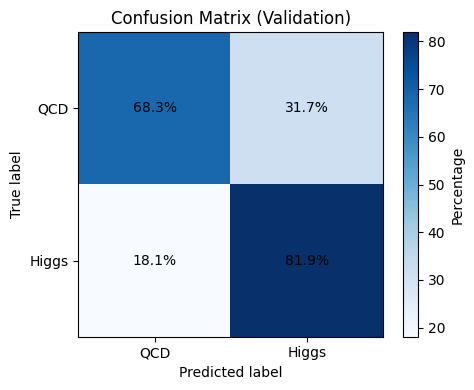

In [39]:
plt.figure(figsize=(5, 4))
plt.imshow(cm_percent, cmap="Blues")
plt.colorbar(label="Percentage")

classes = ["QCD", "Higgs"]
plt.xticks([0, 1], classes)
plt.yticks([0, 1], classes)

for i in range(2):
    for j in range(2):
        plt.text(j, i, f"{cm_percent[i, j]:.1f}%", 
                 ha="center", va="center")

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix (Validation)")
plt.tight_layout()
plt.show()


In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc = accuracy_score(labels, y_pred)
prec = precision_score(labels, y_pred)
rec = recall_score(labels, y_pred)
f1 = f1_score(labels, y_pred)

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")


Accuracy : 0.7585
Precision: 0.7643
Recall   : 0.8189
F1-score : 0.7907
AUC      : 0.8548


In [42]:
import torch
import os

os.makedirs("checkpoints", exist_ok=True)

ckpt_path = "checkpoints/particle_transformer_qcd_higgs.pt"

torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "epoch": epoch,
}, ckpt_path)

print(f" Particle Transformer saved at: {ckpt_path}")


 Particle Transformer saved at: checkpoints/particle_transformer_qcd_higgs.pt


In [43]:
import numpy as np

np.savez(
    "checkpoints/particle_transformer_history.npz",
    train_losses=train_loss,
    val_losses=val_loss,
    val_aucs=val_auc
)


In [44]:
ckpt = torch.load(ckpt_path, map_location=device)

model.load_state_dict(ckpt["model_state_dict"])
optimizer.load_state_dict(ckpt["optimizer_state_dict"])

print("Checkpoint reload , epoch:", ckpt["epoch"])


Checkpoint reload , epoch: 10
